In [1]:
from utils_luke import to_standard_units, formatter, rodrigues
import os
os.chdir("../")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from godot.core import tempo, astro, events
from godot.core.autodif import bridge as br
from godot import cosmos
from godot.model import eventgen, common, prop
import godot.core.util as util
util.suppressLogger()

In [3]:
f=open("HaloOrbit/GateWayOrbit_prop.csv","r")
lines=f.readlines()
print(lines[0])
lines = lines[1:]
f.close()
print(lines)
lines = [[float(element) for element in line.strip().split(",")] for line in lines]
#change to seconds and km
HaloData = np.array([[to_standard_units(line[0], "TU"), to_standard_units(line[1], "LU"), to_standard_units(line[2], "LU"), to_standard_units(line[3], "LU")] for line in lines])
print(HaloData[0:10])
print(HaloData[-1][0]/(24*3600))
print(HaloData)



Time (TU),X (LU),Y (LU),Z (LU),VX (LU/TU),VY (LU/TU),VZ (LU/TU)

['0,1.0196625817475922,3.4173862952063685e-27,-0.18041918731575562,-1.8760072461303471e-13,-0.09805982467069076,-3.0285607115934284e-12\n', '0.004010237096860553,1.0196615668828732,-0.0003932384985572269,-0.18041507352681013,-0.0005061365158997318,-0.09805634751719534,0.0020516512947649818\n', '0.011768066340914464,1.0196538424806556,-0.001153857059821812,-0.18038376114026441,-0.001485238497001299,-0.09802987916796489,0.006020920611298277\n', '0.01953018371817065,1.0196385120317626,-0.0019145894250295159,-0.18032160955989404,-0.002464815683999552,-0.09797733325268698,0.0099933790447479\n', '0.02729736834630814,1.0196155609323667,-0.0026753087372417524,-0.18022854651613246,-0.0034449225927069478,-0.09789863039243761,0.01397008623820836\n', '0.035069810091897906,1.0195849744661956,-0.003435829253461096,-0.18010449271153467,-0.004425539021747235,-0.09779367603224275,0.017951806072684876\n', '0.04284771421733827,1.01954673742

5703.536414367791


(335142.171643162,
 447030.754672266,
 -55944.28880378121,
 55944.294225322796,
 -75650.03547192068,
 8266.401799907326)

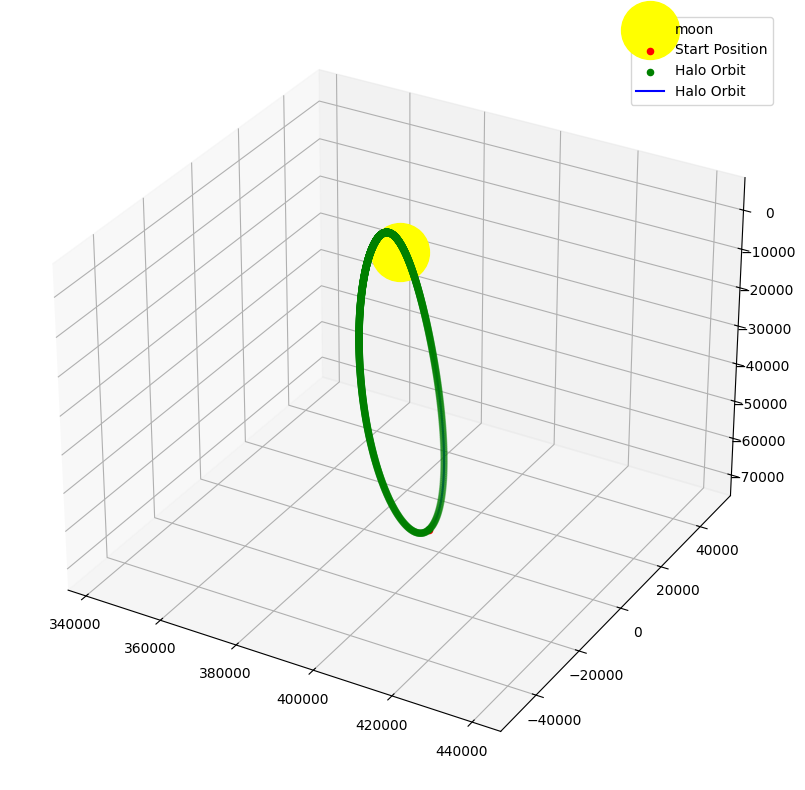

In [4]:
print(np.min([np.linalg.norm([to_standard_units(1, "LU"), 0, 0]-HaloPos[1:]) for HaloPos in HaloData]))
# %matplotlib tk
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
moon_radius = 1737.4
ax.scatter(to_standard_units(1, "LU"), 0, 0, s=moon_radius, color="yellow", label="moon")
# ax.scatter(to_standard_units(1, "LU"), 0, 0, s=100,  color="yellow", label="moon")
ax.scatter(HaloData[0][1], HaloData[0][2], HaloData[0][3], color='red', label='Start Position')

ax.scatter(HaloData[:,1], HaloData[:,2], HaloData[:,3], color='green', label='Halo Orbit')
ax.plot(HaloData[:,1], HaloData[:,2], HaloData[:,3], color='blue', label='Halo Orbit')
ax.legend()
ax.axis("equal")

In [5]:
uni_config=cosmos.util.load_yaml("universe2.yml")
uni = cosmos.Universe(uni_config)

ep1 = tempo.Epoch('2026-01-01T00:00:00 TT')
ep2 = tempo.Epoch('2026-01-16T00:00:00 TT')
ran = tempo.EpochRange( ep1, ep2 )
timestep=30.0
grid = ran.createGrid(timestep) # 60 seconds stepsize
eps = 1e-6
tol = 1e-6
print(len(grid))
print(ep2-ep1)
print(ep1-ep2)

43201
1296000.0
-1296000.0


In [6]:
uni_config=cosmos.util.load_yaml("universe2.yml")
uni = cosmos.Universe(uni_config)
frames = uni.frames
icrf = frames.axesId('ICRF')
moonPoint=frames.pointId('Moon')
earthPoint=frames.pointId('Earth')

moonData=np.asarray([frames.vector3(earthPoint, moonPoint, icrf, ep) for ep in grid])
print(moonData[0:10])

[[144325.74426347 289584.15167847 160158.91839529]
 [144295.61427751 289595.66801048 160164.09382799]
 [144265.48316663 289607.18212698 160169.26803177]
 [144235.35093107 289618.69402788 160174.44100657]
 [144205.21757104 289630.20371308 160179.61275236]
 [144175.08308678 289641.71118249 160184.78326908]
 [144144.94747852 289653.21643599 160189.9525567 ]
 [144114.81074648 289664.71947351 160195.12061517]
 [144084.6728909  289676.22029493 160200.28744444]
 [144054.533912   289687.71890017 160205.45304446]]


In [7]:
class HaloOrbitEmphimeris:
    def __init__(self, timestep, grid):
        self.timestep = timestep
        self.grid = grid
        self.x_axis_moon = np.array([to_standard_units(1, "LU"), 0, 0])
        self.x_axis_moon_length = np.linalg.norm(self.x_axis_moon)

    def epoch_to_seconds(self, epoch):
        return epoch - self.grid[0]
    def seconds_to_epoch(self, seconds):
        return self.grid[0] + seconds
    
    def load_data(self, HaloDataDir):
        f=open(HaloDataDir,"r")
        lines=f.readlines()
        f.close()
        print(lines[0])
        lines = lines[1:]
        lines = [[float(element) for element in line.strip().split(",")] for line in lines]
        self.HaloData = np.array([[to_standard_units(line[0], "TU"), to_standard_units(line[1], "LU"), to_standard_units(line[2], "LU"), to_standard_units(line[3], "LU")] for line in lines])
        self.HaloOrbitTime = self.HaloData[-1][0]

    def createEmphimeris(self, moonData):# can be multiprocessed
        self.emph = np.zeros((len(self.grid), 3))
        for i, ep in enumerate(self.grid):
            time= self.epoch_to_seconds(ep)
            orbits=np.floor(time/self.HaloOrbitTime) #find the amount of orbits that has happened
            # HaloOrbitPos = np.array(self.HaloData[self.closest_time(time, orbits)][1:])
            HaloOrbitPos = np.array(self.HaloData[self.closest_time(time, orbits)])
            orbit_time = HaloOrbitPos[0]
            # print(orbit_time)
            HaloOrbitPos = HaloOrbitPos[1:]
            HaloOrbitLen = np.linalg.norm(self.x_axis_moon- HaloOrbitPos)
            moonPos = np.array(moonData[i])
            moon_len= np.linalg.norm(moonPos)
            R=self.rotation_matrix(moonPos)
            pos =R@HaloOrbitPos
            # self.emph[i]=self.rodrigues(moonPos, HaloOrbitPos)
            self.emph[i]=(pos/np.linalg.norm(pos))*(moon_len+HaloOrbitLen) # it is a little off (projection)
            # print(self.emph[i])
    
    def createEmphimeris_with_index(self, moonData, index):# can be multiprocessed
        self.emph = np.zeros((len(self.grid), 3))
        moonPos = np.array(moonData[index])
        moon_len= np.linalg.norm(moonPos)
        for i, ep in enumerate(self.grid):
            time= self.epoch_to_seconds(ep)
            orbits=np.floor(time/self.HaloOrbitTime) #find the amount of orbits that has happened
            HaloOrbitPos = np.array(self.HaloData[self.closest_time(time, orbits)][1:])
            HaloOrbitLen= np.linalg.norm(self.x_axis_moon- HaloOrbitPos)
            R=self.rotation_matrix(moonPos)
            pos=R@HaloOrbitPos
            # self.emph[i]=(pos/np.linalg.norm(pos))*(moon_len+HaloOrbitLen) # it is a little off (projection)
            self.emph[i]=(pos/np.linalg.norm(pos))*(np.sqrt(moon_len**2+HaloOrbitLen**2)) # it is a little off (projection)

            # print(self.emph[i])
    
    def rodrigues(self, moonPos, HaloOrbitPos):
        # rot_axis= np.cross(moonPos, self.x_axis_moon)/np.linalg.norm(np.cross(moonPos, self.x_axis_moon))
        rot_axis= np.cross(moonPos, self.x_axis_moon)
        rot_axis = rot_axis/np.linalg.norm(rot_axis)
        angle = -np.arccos(np.dot(self.x_axis_moon, moonPos)/(np.linalg.norm(self.x_axis_moon)*np.linalg.norm(moonPos)))
        # angle = -np.arccos(np.dot(self.x_axis_moon, moonPos))
        # rodrigues rotation formula
        v1=HaloOrbitPos*np.cos(angle)
        v2=np.cross(rot_axis, HaloOrbitPos)*np.sin(angle)
        v3=rot_axis*np.dot(rot_axis, HaloOrbitPos)*(1-np.cos(angle))
        return v1+v2+v3
    
    def rotation_matrix(self, moonPos):
        # determine rotation matrix
        rot_axis= np.cross(moonPos, self.x_axis_moon)
        rot_axis = rot_axis/np.linalg.norm(rot_axis)
        angle = -np.arccos(np.dot(self.x_axis_moon, moonPos)/(np.linalg.norm(self.x_axis_moon)*np.linalg.norm(moonPos)))
        R=np.array([[rot_axis[0]**2*(1-np.cos(angle))+np.cos(angle),                        rot_axis[0]*rot_axis[1]*(1-np.cos(angle))-rot_axis[2]*np.sin(angle),    rot_axis[0]*rot_axis[2]*(1-np.cos(angle))+rot_axis[1]*np.sin(angle)],
                    [rot_axis[0]*rot_axis[1]*(1-np.cos(angle))+rot_axis[2]*np.sin(angle),   rot_axis[1]**2*(1-np.cos(angle))+np.cos(angle),                         rot_axis[1]*rot_axis[2]*(1-np.cos(angle))-rot_axis[0]*np.sin(angle)],
                    [rot_axis[0]*rot_axis[2]*(1-np.cos(angle))-rot_axis[1]*np.sin(angle),   rot_axis[1]*rot_axis[2]*(1-np.cos(angle))+rot_axis[0]*np.sin(angle),    rot_axis[2]**2*(1-np.cos(angle))+np.cos(angle)]])
        return R

    def closest_time(self, time, orbits): #missing interpolation (godot autodif)
        tempTime = time - orbits * self.HaloOrbitTime
        if tempTime < 0:
            raise ValueError("Time is less than 0")
        return np.abs(tempTime-self.HaloData[:,0]).argmin()




In [8]:
print(to_standard_units(0.004010237096860553, "TU")/30)
print(1535.8446135927516/30)
print(to_standard_units(0.011768066340914464, "TU")/30)


51.194820453091715
51.194820453091715
150.23152717699207


In [9]:
haloSat=HaloOrbitEmphimeris(timestep, grid)
haloSat.load_data("HaloOrbit/GateWayOrbit_prop.csv")
print(type(haloSat.x_axis_moon))
print(haloSat.HaloData[:, 1:])
# print(max(np.linalg.norm(haloSat.HaloData[:, 1:]-haloSat.x_axis_moon)))

Time (TU),X (LU),Y (LU),Z (LU),VX (LU/TU),VY (LU/TU),VZ (LU/TU)

<class 'numpy.ndarray'>
[[ 3.97365567e+05  1.33176569e-21 -7.03098986e+04]
 [ 3.97365172e+05 -1.53246223e+02 -7.03082954e+04]
 [ 3.97362161e+05 -4.49661558e+02 -7.02960929e+04]
 ...
 [ 3.97360459e+05  5.50642599e+02 -7.02891935e+04]
 [ 3.97364481e+05  2.53916690e+02 -7.03054971e+04]
 [ 3.97365567e+05  6.37139760e-08 -7.03098986e+04]]


790202.7658414685


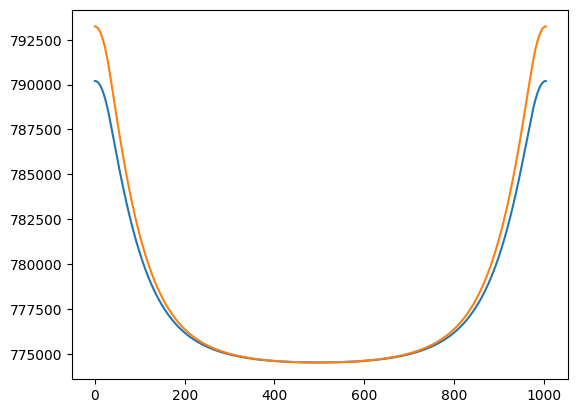

In [10]:
dist_luk = np.linalg.norm(haloSat.HaloData[:,1:]+haloSat.x_axis_moon, axis=1)
plt.plot(dist_luk)
print(max(dist_luk))
x = np.linalg.norm(haloSat.HaloData[:,1:],axis=1)
y = np.linalg.norm(haloSat.x_axis_moon)
z = x+y
plt.plot(z)

In [11]:
# haloSat.createEmphimeris(moonData)

# fig=plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(*haloSat.emph.T, color='black', label='Halo Orbit')
# ax.scatter(*haloSat.emph[0], color='red', label='Start Position')
# ax.plot(*moonData.T, color='green', label='Moon Orbit')
# ax.scatter(0, 0, 0, s=10, color="blue", label="earth")

[-373936.63573333   86561.89640518   33493.94537499]
[-382057.05533107   60822.3112842    19381.6283151 ]
[-387783.17658635   34717.49111985    5154.81801314]
[-391115.61749228    8412.40920226   -9097.63403668]
[-392068.55702265  -17931.87818339  -23289.44001689]
[-390668.77220467  -44158.81659662  -37337.15965011]
[-386954.72267544  -70116.81115821  -51160.41730634]
[-380975.69653874  -95659.57817197  -64682.06412084]
[-372791.02612694 -120646.41121871  -77828.29646685]
[-362469.37782353 -144942.38120126  -90528.74139191]


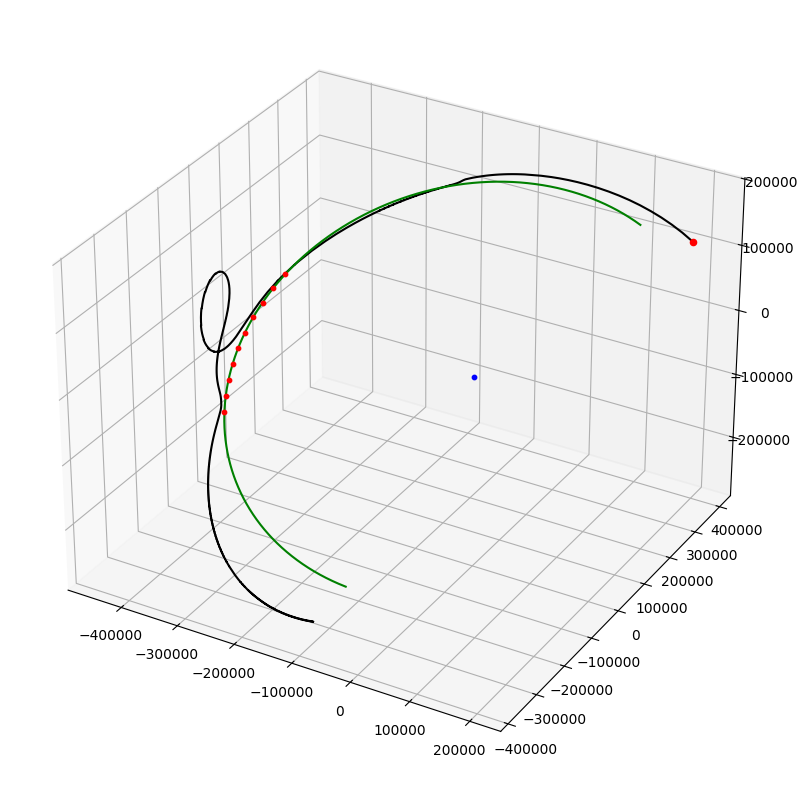

In [12]:
haloSat.createEmphimeris(moonData)

fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*haloSat.emph.T, color='black', label='Halo Orbit')
ax.scatter(*haloSat.emph[0], color='red', label='Start Position')
ax.plot(*moonData.T, color='green', label='Moon Orbit')
ax.scatter(0, 0, 0, s=10, color="blue", label="earth")
indexes=np.arange(20000, 30000, 1000, dtype=int)
for index in indexes:
    print(moonData[index].T)
    ax.scatter(*moonData[index].T, s=10, color="red", label="moon")

(-114834.49937729641,
 107800.09363756639,
 -106414.70416588627,
 116219.88884897652,
 -91683.61593408798,
 75292.32882705913)

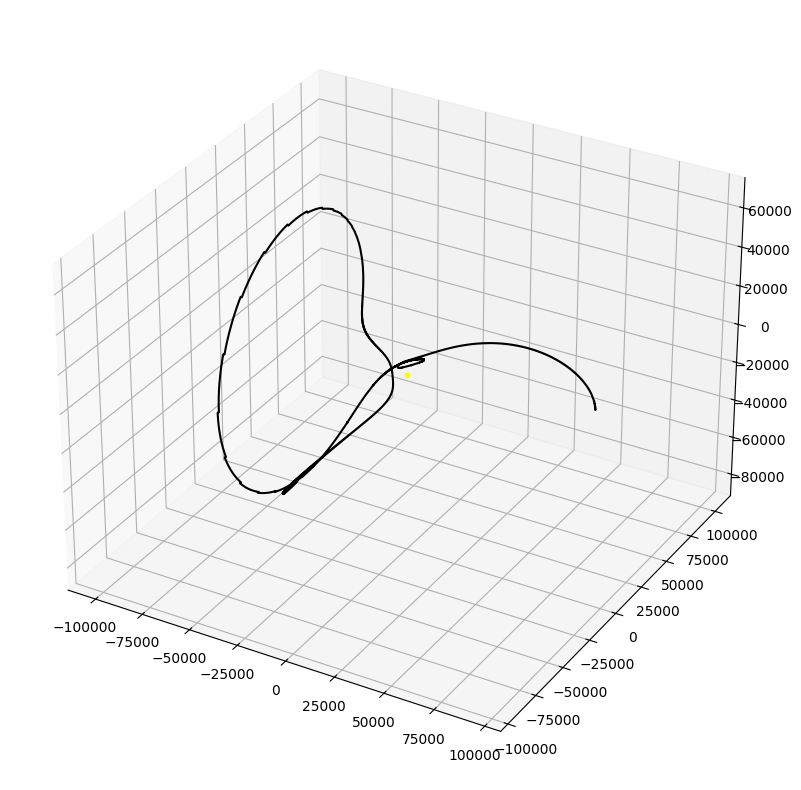

In [13]:

moon_halo=haloSat.emph-moonData
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*moon_halo.T, color='black', label='Halo Orbit')
ax.scatter(0, 0, 0, s=10, color="yellow", label="moon")
ax.axis("equal")

(-557753.7572197109,
 312604.93495989253,
 -425569.4912986548,
 444789.20088094857,
 -376398.2620879866,
 276370.75704671605)

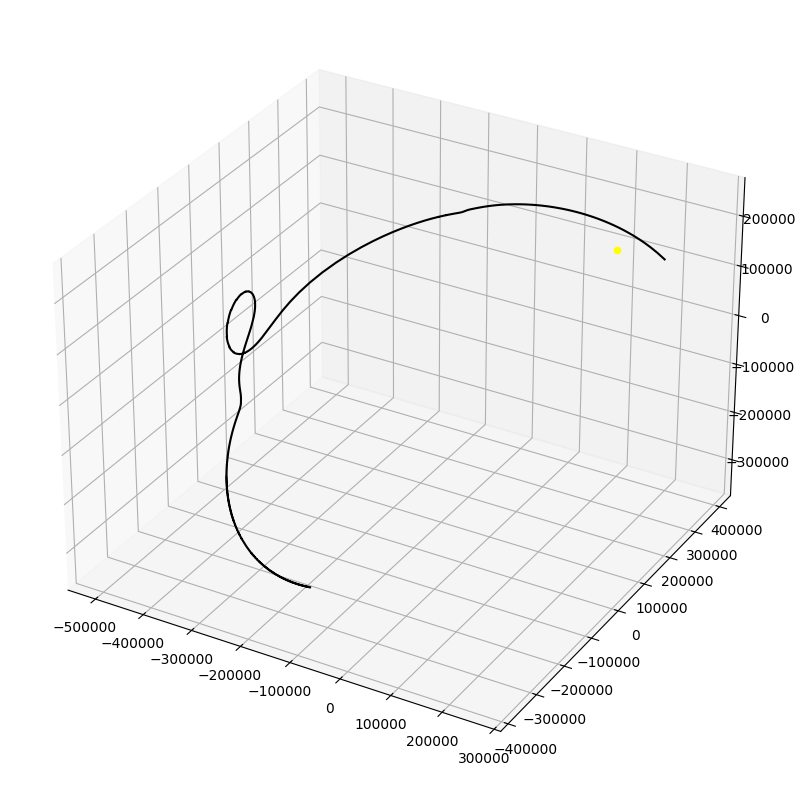

In [14]:
fig = plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(*moonData[1], color='yellow', label='moon position')
ax.plot(*haloSat.emph.T, color='black', label='Moon Orbit')
ax.axis("equal")


In [15]:

# length=len(haloSat.grid)
# indexes=np.random.randint(0, length, 10)
# fig=plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(0, 0, 0, s=10, color="blue", label="earth")
# ax.scatter([to_standard_units(1, "LU")], [0], [0], s=10, color="blue", label="moon init")
# for index in indexes:
#     haloSat.createEmphimeris_with_index(moonData, index)
#     ax.plot(*haloSat.emph.T, color='black', label='Halo Orbit')
#     ax.scatter(*moonData[index], color='yellow', label='moon position')
#     ax.plot(*moonData.T, color='green', label='Moon Orbit')

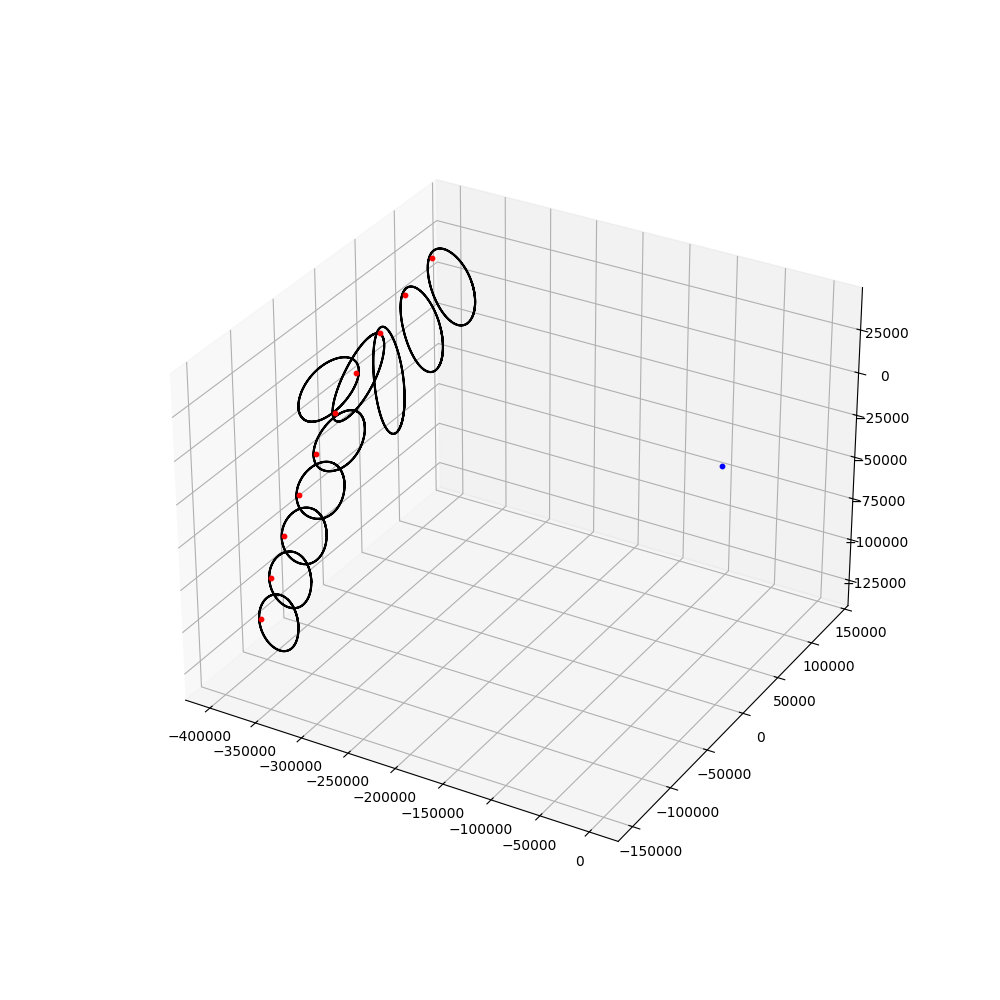

In [16]:
%matplotlib widget
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection="3d")
indexes=np.arange(20000, 30000, 1000, dtype=int)
ax.scatter(0,0,0, s=10, color="blue")
for index in indexes:
    ax.scatter(*moonData[index].T, s=10, color="red", label="moon")
    haloSat.createEmphimeris_with_index(moonData, index)
    ax.plot(*haloSat.emph.T, color="black", label="halo Orbit")